<a href="https://colab.research.google.com/github/YANZHANLIN/Pytorch_exercise/blob/main/CNN241011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# COURSE14

## import MNIST data

In [20]:
# convert MNIST images into a tensor of 4 dimensions(# of images, h, w, c)
transform = transforms.ToTensor()

In [21]:
# train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [22]:
# test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [23]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [24]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [25]:
'''
!pwd #what is this
!ls  # what is this
!cd ../
!pwd
!ls
!cd /content
'''

'\n!pwd #what is this\n!ls  # what is this\n!cd ../\n!pwd\n!ls\n!cd /content\n'

In [26]:
# !pwd

## build, train, test CNN model

In [27]:
# create a small batch size of images   10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### example of cnn layers

In [28]:
# define CNN model
# describe conv layer and what it is doing (2 conv layers)
# example only here
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1)

In [30]:
# grab 1 mnist image/record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [47]:
X_train.shape

torch.Size([1, 28, 28])

In [55]:
x = X_train.view(1, 1, 28, 28)  # why 4d ? manually make index 1? .view()? .reshape()?

In [56]:
# first conv layer
x =F.relu(conv1(x)) # rectified(what is this??) linear unit for activation function

In [57]:
# 1 single image, 6 is the filters, 24 is
x.shape

torch.Size([1, 6, 24, 24])

In [58]:
# first pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)   # max_pool2d ??

In [59]:
x.shape

torch.Size([1, 6, 12, 12])

In [60]:
# second conv layer
x = F.relu(conv2(x))

In [61]:
x.shape

torch.Size([1, 12, 8, 8])

In [62]:
# second pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [63]:
x.shape

torch.Size([1, 12, 4, 4])

In [64]:
# 1, 12, 4, 4 is index, c, h, w ??

### !!!cnn model

In [66]:
# model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    # super class constructor
    super().__init__()

    # define conv layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1)

    # fully connected layer
    self.fc1 = nn.Linear(in_features=4*4*12, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # forward pass
  def forward(self, X):

    # first pass
    x = F.relu(self.conv1(X))
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    # second pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    # flatten  view or reshape
    x = x.reshape(-1, 4*4*12) # -1 for what? so we can vary batch size

    # fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return F.log_softmax(x, dim=1)  # what is this and why???

In [68]:
# create an instance of our model
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [77]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # smaller, longer time to train

### Training and test model

In [79]:
import time
start_time = time.time()

# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop over epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # train
    model.train()  # Set model to training mode
    for b, (X_train, y_train) in enumerate(train_loader):
        y_pred = model(X_train)  # Get predicted values from the training set
        loss = criterion(y_pred, y_train)  # Calculate loss

        # Add up the number of correct predictions
        predicted = torch.max(y_pred, 1)[1]  # Get the predicted class
        batch_corr = (predicted == y_train).sum().item()  # Sum correct predictions
        trn_corr += batch_corr

        # Update our parameters
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagate the loss
        optimizer.step()       # Update the weights

        # Print out the result every 600 batches
        if b % 600 == 0:
            print(f'Epoch: {i+1}/{epochs}  Batch: {b}  Loss: {loss.item()}')

    # Track training metrics after each epoch
    train_losses.append(loss.item())  # Append the loss of the last batch
    train_correct.append(trn_corr)    # Append total correct predictions for the epoch

    # test
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for testing
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val, 1)[1]
            tst_corr += (predicted == y_test).sum().item()  # Sum correct predictions for the test set

        loss = criterion(y_val, y_test)  # Calculate test loss from the last batch
        test_losses.append(loss.item())  # Append test loss
        test_correct.append(tst_corr)    # Append total correct predictions for the test set

# Calculate total time taken for training
current_time = time.time()
total_time = current_time - start_time
print(f'Total training time: {total_time:.2f} seconds.')


Epoch: 1/5  Batch: 0  Loss: 2.302182674407959
Epoch: 1/5  Batch: 600  Loss: 0.5378603935241699
Epoch: 1/5  Batch: 1200  Loss: 0.07694806158542633
Epoch: 1/5  Batch: 1800  Loss: 0.2406354695558548
Epoch: 1/5  Batch: 2400  Loss: 0.0735328420996666
Epoch: 1/5  Batch: 3000  Loss: 0.11094801127910614
Epoch: 1/5  Batch: 3600  Loss: 0.013539418578147888
Epoch: 1/5  Batch: 4200  Loss: 0.0106624411419034
Epoch: 1/5  Batch: 4800  Loss: 0.18083587288856506
Epoch: 1/5  Batch: 5400  Loss: 0.3265005052089691
Epoch: 2/5  Batch: 0  Loss: 0.011314285919070244
Epoch: 2/5  Batch: 600  Loss: 0.028810376301407814
Epoch: 2/5  Batch: 1200  Loss: 0.024639848619699478
Epoch: 2/5  Batch: 1800  Loss: 0.019333060830831528
Epoch: 2/5  Batch: 2400  Loss: 0.0019168423023074865
Epoch: 2/5  Batch: 3000  Loss: 0.022987091913819313
Epoch: 2/5  Batch: 3600  Loss: 0.000726044992916286
Epoch: 2/5  Batch: 4200  Loss: 0.07474420964717865
Epoch: 2/5  Batch: 4800  Loss: 0.0065795378759503365
Epoch: 2/5  Batch: 5400  Loss: 0.00

## graph CNN results

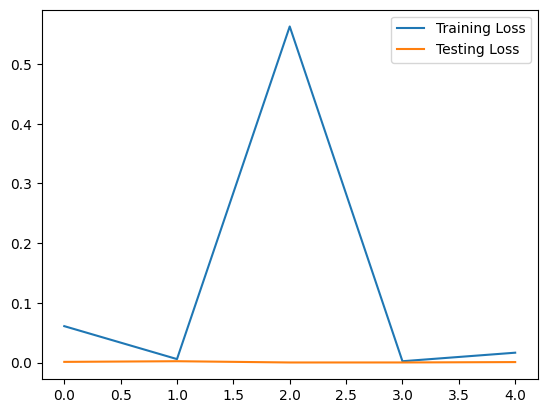

In [80]:
# graph the loss at epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()

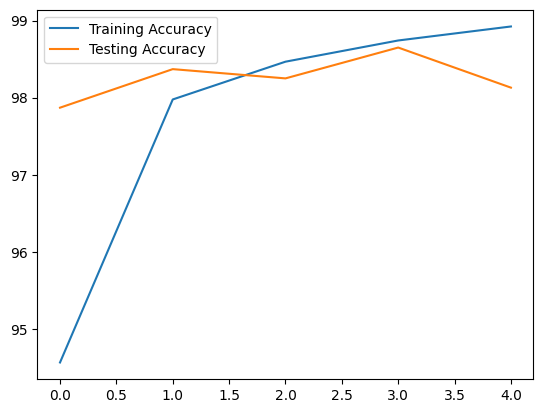

In [82]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.legend()

In [83]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [85]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y).sum().item()
  print(f'Test accuracy: {correct / len(test_data)}')

Test accuracy: 0.9813


In [88]:
# did for correct
correct/len(test_data)*100

98.13

## test on an image

In [89]:
# grab an image
test_data[410]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [90]:
# grab just the data
test_data[410][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [91]:
# reshape it
test_data[410][0].view(1, 1, 28, 28)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

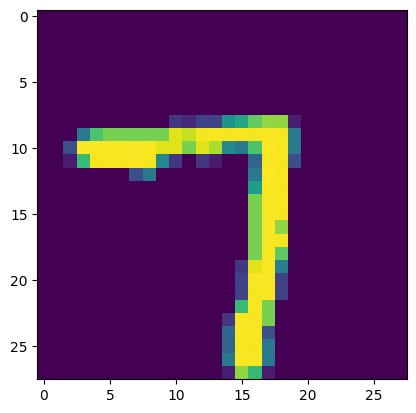

In [92]:
plt.imshow(test_data[410][0].view(28, 28))

In [94]:
# pass the image throught model
model.eval()
with torch.no_grad():   # why this ???
  new_prediction = model(test_data[410][0].view(1, 1, 28, 28))

In [95]:
# check the new prediction
new_prediction

tensor([[-2.3877e+01, -1.0902e+01, -1.3367e+01, -1.3977e+01, -1.0814e+01,
         -2.0034e+01, -3.2285e+01, -4.9471e-05, -1.8908e+01, -1.1671e+01]])

In [96]:
new_prediction.argmax()

tensor(7)